c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_tools\_dataframe.py:177:FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
C:\Users\Juan Marco\AppData\Local\Temp\ipykernel_27176\1076269624.py:57:FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


Resultados de la Simulación de Monte Carlo a 5 años:
Valor final mediano proyectado: $2,790,548.39 MXN
Rango de confianza del 95%: Entre $865,766.81 y $8,527,187.28 MXN

Probabilidad de alcanzar Universidad de Utrecht ($1,772,042 MXN): 77.80%
Probabilidad de alcanzar Universidad de Wageningen ($1,517,724 MXN): 84.40%
Probabilidad de alcanzar Universidad de Lund ($1,499,773 MXN): 85.00%
Probabilidad de alcanzar TU Delft ($1,474,650 MXN): 85.70%
Probabilidad de alcanzar DTU ($1,283,101 MXN): 90.00%
Probabilidad de alcanzar Universidad de Investigación PSL ($644,674 MXN): 99.00%
Probabilidad de alcanzar TU Alemana (TU Múnich, KIT, RWTH Aachen) (rango $522,408-$652,008 MXN):
  >= mínimo: 99.50%   >= máximo: 98.80%


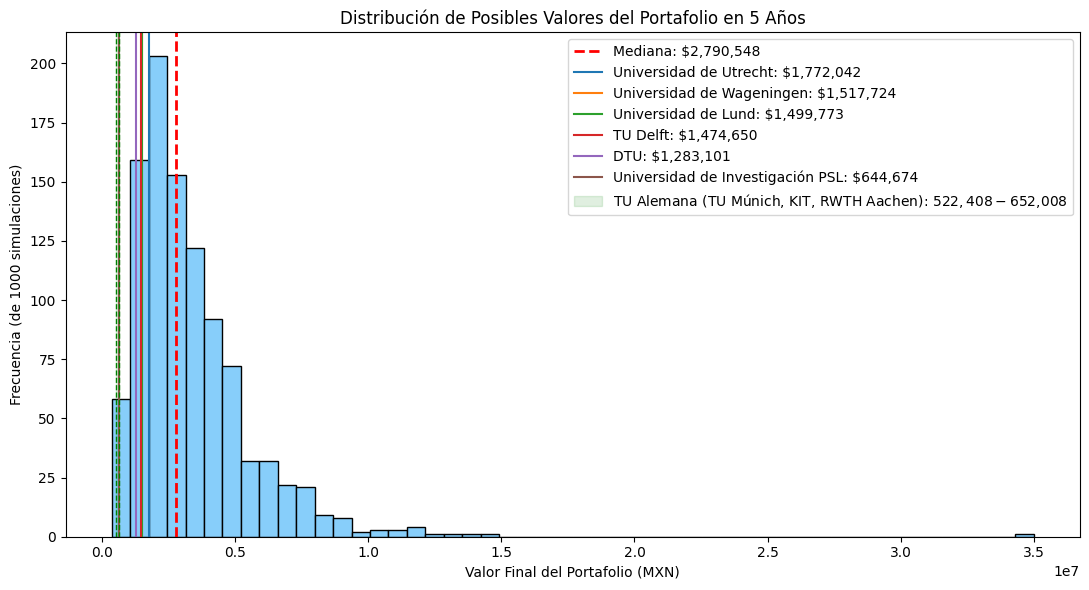

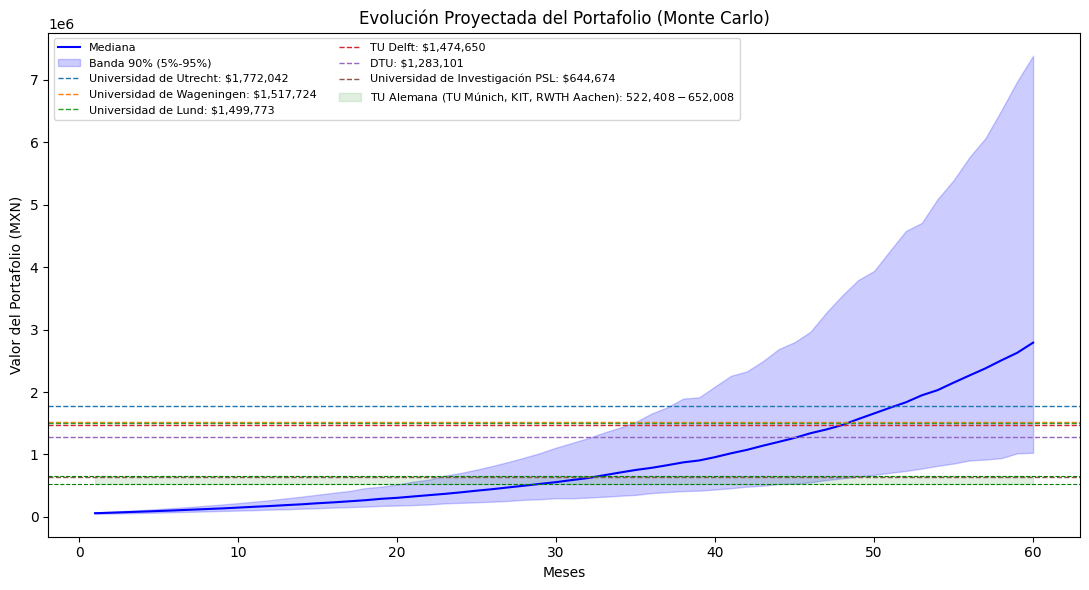

In [1]:
import lseg.data as ld  # Importa la librería de datos LSEG (Refinitiv) para descargar históricos
import numpy as np       # Importa NumPy para cálculos numéricos y simulación
import pandas as pd      # Importa pandas para manipulación de datos
import matplotlib.pyplot as plt  # Importa Matplotlib para visualizaciones

# --- Configuración ---
ld.open_session()  # Abre la sesión con LSEG para poder realizar consultas de datos

# Capital inicial (inversión única al inicio)
initial_rics = [  # Lista de RICs (tickers) en los que se invierte inicialmente
    "EXLS.OQ", "4901.T", "2301.TW", "REL.L", "MSFT.OQ",
# Diversificación geográfica/sectorial
    "ZOREN.IS", "GWIND.IS", "NATEN.IS", "ESEN.IS", "MAGEN.IS"
 ]
initial_weights = np.array([0.09, 0.08, 0.09, 0.09, 0.18, 0.05, 0.10, 0.10, 0.10, 0.12])  # Pesos de la inversión inicial por activo (suma ≈ 1)

# Aportaciones mensuales (se reparten diferente)
monthly_rics = [  # Lista de RICs usados para las aportaciones mensuales
    "4901.T", "2301.TW", "ZOREN.IS", "GWIND.IS", 
    "NATEN.IS", "ESEN.IS", "MAGEN.IS"
]
monthly_weights = np.array([0.09, 0.09, 0.06, 0.10, 0.11, 0.20, 0.36])  # Pesos para las aportaciones mensuales


# Monto de inversión y horizonte
initial_investment = 50000      # Monto único que se invierte al inicio (MXN)
monthly_contribution = 5000     # Monto que se aporta cada mes (MXN)
investment_horizon_years = 5    # Horizonte de inversión en años
simulations = 1000              # Número de escenarios Monte Carlo a simular

# Metas/objetivos actualizados (MXN)
goals = {  # 6 metas de costo fijo
    "Universidad de Utrecht": 1772042,
    "Universidad de Wageningen": 1517724,
    "Universidad de Lund": 1499773,
    "TU Delft": 1474650,
    "DTU": 1283101,
    "Universidad de Investigación PSL": 644674,
}
range_goal_name = "TU Alemana (TU Múnich, KIT, RWTH Aachen)"  # Objetivo con costo en rango
range_goal_min = 522408  # Límite inferior del rango (MXN)
range_goal_max = 652008  # Límite superior del rango (MXN)

# --- Datos históricos ---
end_date = pd.to_datetime('today')  # Fecha de fin: hoy
start_date = end_date - pd.DateOffset(years=5)  # Fecha de inicio: 5 años atrás
all_rics = list(set(initial_rics + monthly_rics))  # Unión única de tickers necesarios

historical_data = ld.get_history(  # Descarga precios históricos ajustados
    all_rics,   # Lista completa de RICs a consultar
    fields='TR.PriceClose', # Campo de precio de cierre ajustado por dividendos
    start=start_date, # Fecha de inicio del histórico
    end=end_date # Fecha de fin del histórico
)

# --- Rendimientos ---
daily_returns = historical_data.pct_change().dropna()  # Computa rendimientos diarios y elimina NaN
mean_returns = daily_returns.mean()  # Media de rendimientos diarios por activo
cov_matrix = daily_returns.cov()     # Matriz de covarianza de rendimientos diarios

annual_mean_returns = mean_returns * 252  # Anualiza retornos (252 días hábiles)
annual_cov_matrix = cov_matrix * 252      # Anualiza covarianzas

# --- Simulación Monte Carlo ---
num_months = investment_horizon_years * 12  # Número total de meses del horizonte
trajectories = np.zeros((simulations, num_months))  # Matriz para guardar trayectorias simuladas

for i in range(simulations):  # Itera por cada simulación independiente
    # Inversión inicial: distribuida según initial_weights
    init_returns = np.random.multivariate_normal(  # Muestra de retornos mensuales correlacionados para activos iniciales
        annual_mean_returns[initial_rics] / 12,   # Medias mensuales (anual/12)
        annual_cov_matrix.loc[initial_rics, initial_rics] / 12  # Covarianzas mensuales (anual/12)
    )
    initial_value = np.dot(init_returns, initial_weights)  # Retorno del portafolio en el mes 0 por pesos iniciales
    total_value = initial_investment * (1 + initial_value)  # Valor del portafolio tras aplicar retorno inicial

    for month in range(num_months):  # Itera mes a mes
        # Simular aportaciones con monthly_rics
        monthly_return = np.random.multivariate_normal(  # Muestra de retornos mensuales para activos de aportación
            annual_mean_returns[monthly_rics] / 12,      # Medias mensuales de esos activos
            annual_cov_matrix.loc[monthly_rics, monthly_rics] / 12  # Covarianzas mensuales
        )
        portfolio_monthly_return = np.dot(monthly_return, monthly_weights)  # Retorno del portafolio por pesos de aportación

        # Portafolio crece con el retorno y se agrega la aportación mensual
        total_value = total_value * (1 + portfolio_monthly_return) + monthly_contribution  # Actualiza valor
        trajectories[i, month] = total_value  # Guarda el valor del portafolio en este mes para la simulación i

final_values = trajectories[:, -1]  # Toma el valor final (al último mes) de cada simulación

# --- Resultados ---
median_final_value = np.median(final_values)  # Mediana de valores finales
confidence_interval_95 = np.percentile(final_values, [2.5, 97.5])  # Intervalo 95% (percentiles 2.5 y 97.5)

# Probabilidades por objetivo
prob_by_goal = {name: float(np.mean(final_values >= value) * 100) for name, value in goals.items()}  # % simulaciones que alcanzan cada meta fija
range_goal_prob_min = float(np.mean(final_values >= range_goal_min) * 100)  # % que supera el mínimo del rango
range_goal_prob_max = float(np.mean(final_values >= range_goal_max) * 100)  # % que supera el máximo del rango

print(f"Resultados de la Simulación de Monte Carlo a {investment_horizon_years} años:")  # Encabezado resultados
print(f"Valor final mediano proyectado: ${median_final_value:,.2f} MXN")  # Imprime mediana formateada
print(f"Rango de confianza del 95%: Entre ${confidence_interval_95[0]:,.2f} y ${confidence_interval_95[1]:,.2f} MXN")  # Imprime intervalo 95%
print()  # Línea en blanco para legibilidad
for name, value in goals.items():  # Recorre metas fijas
    print(f"Probabilidad de alcanzar {name} (${value:,.0f} MXN): {prob_by_goal[name]:.2f}%")  # Imprime probabilidad por meta fija
print(f"Probabilidad de alcanzar {range_goal_name} (rango ${range_goal_min:,.0f}-${range_goal_max:,.0f} MXN):")  # Encabezado para meta en rango
print(f"  >= mínimo: {range_goal_prob_min:.2f}%   >= máximo: {range_goal_prob_max:.2f}%")  # Imprime probabilidades del rango

# --- Visualización 1: Histograma ---
plt.figure(figsize=(11, 6))  # Crea figura para el histograma
plt.hist(final_values, bins=50, edgecolor='black', color='#87CEFA')  # Histograma de valores finales
plt.title('Distribución de Posibles Valores del Portafolio en 5 Años')  # Título de la gráfica
plt.xlabel('Valor Final del Portafolio (MXN)')  # Etiqueta del eje X
plt.ylabel(f'Frecuencia (de {simulations} simulaciones)')  # Etiqueta del eje Y con número de simulaciones
plt.axvline(median_final_value, color='red', linestyle='dashed', linewidth=2,  # Línea vertical en la mediana
            label=f'Mediana: ${median_final_value:,.0f}')

# Líneas para cada objetivo fijo
color_cycle = plt.cm.tab10.colors  # Paleta de colores para distinguir metas
for idx, (name, value) in enumerate(goals.items()):  # Recorre metas fijas para dibujar líneas
    plt.axvline(value, color=color_cycle[idx % len(color_cycle)], linestyle='solid', linewidth=1.5,  # Línea en cada costo
                label=f"{name}: ${value:,.0f}")  # Etiqueta con nombre y costo

# Banda para el objetivo con rango (TU Alemana)
plt.axvspan(range_goal_min, range_goal_max, color='green', alpha=0.12,  # Banda sombreada entre mínimo y máximo
            label=f'{range_goal_name}: ${range_goal_min:,.0f}-${range_goal_max:,.0f}')  # Etiqueta del rango
plt.axvline(range_goal_min, color='green', linestyle='--', linewidth=1)  # Línea punteada en el mínimo
plt.axvline(range_goal_max, color='green', linestyle='--', linewidth=1)  # Línea punteada en el máximo
plt.legend()  # Muestra la leyenda
plt.tight_layout()  # Ajusta la figura para evitar cortes
plt.show()  # Muestra el histograma

# --- Visualización 2: Curva de crecimiento con bandas ---
months = np.arange(1, num_months+1)  # Vector de meses (1..num_months)
median_curve = np.percentile(trajectories, 50, axis=0)  # Curva de la mediana por mes
p5_curve = np.percentile(trajectories, 5, axis=0)       # Curva P5 (límite inferior de banda)
p95_curve = np.percentile(trajectories, 95, axis=0)     # Curva P95 (límite superior de banda)

plt.figure(figsize=(11, 6))  # Crea figura para la evolución temporal
plt.plot(months, median_curve, color='blue', label='Mediana')  # Dibuja la mediana
plt.fill_between(months, p5_curve, p95_curve, color='blue', alpha=0.2,  # Rellena banda 5%-95%
                 label='Banda 90% (5%-95%)')

# Líneas horizontales para objetivos fijos
for idx, (name, value) in enumerate(goals.items()):  # Recorre metas fijas
    plt.axhline(value, color=color_cycle[idx % len(color_cycle)], linestyle='--', linewidth=1,  # Línea horizontal a cada costo
                label=f"{name}: ${value:,.0f}")  # Etiqueta del objetivo

# Banda horizontal para objetivo con rango
plt.fill_between(months, range_goal_min, range_goal_max, color='green', alpha=0.12,  # Banda entre mínimo y máximo
                 label=f'{range_goal_name}: ${range_goal_min:,.0f}-${range_goal_max:,.0f}')  # Etiqueta del rango
plt.axhline(range_goal_min, color='green', linestyle='--', linewidth=0.8)  # Línea en mínimo
plt.axhline(range_goal_max, color='green', linestyle='--', linewidth=0.8)  # Línea en máximo

plt.title('Evolución Proyectada del Portafolio (Monte Carlo)')  # Título de la gráfica
plt.xlabel('Meses')  # Etiqueta eje X
plt.ylabel('Valor del Portafolio (MXN)')  # Etiqueta eje Y
plt.legend(loc='best', ncol=2, fontsize=8)  # Leyenda optimizada
plt.tight_layout()  # Ajusta el layout
plt.show()  # Muestra la gráfica

In [3]:
prob_by_goal

{'Universidad de Utrecht': 77.8,
 'Universidad de Wageningen': 84.39999999999999,
 'Universidad de Lund': 85.0,
 'TU Delft': 85.7,
 'DTU': 90.0,
 'Universidad de Investigación PSL': 99.0}

Archivos exportados:
- outputs\final_values.csv
- outputs\trajectories_summary.csv
- outputs\probabilities_summary.csv


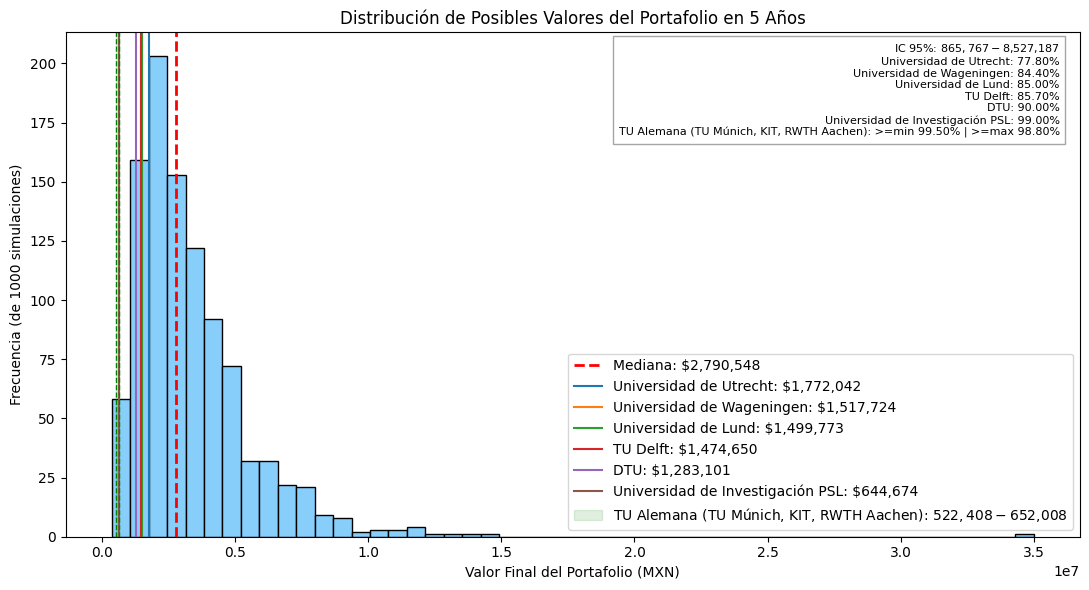

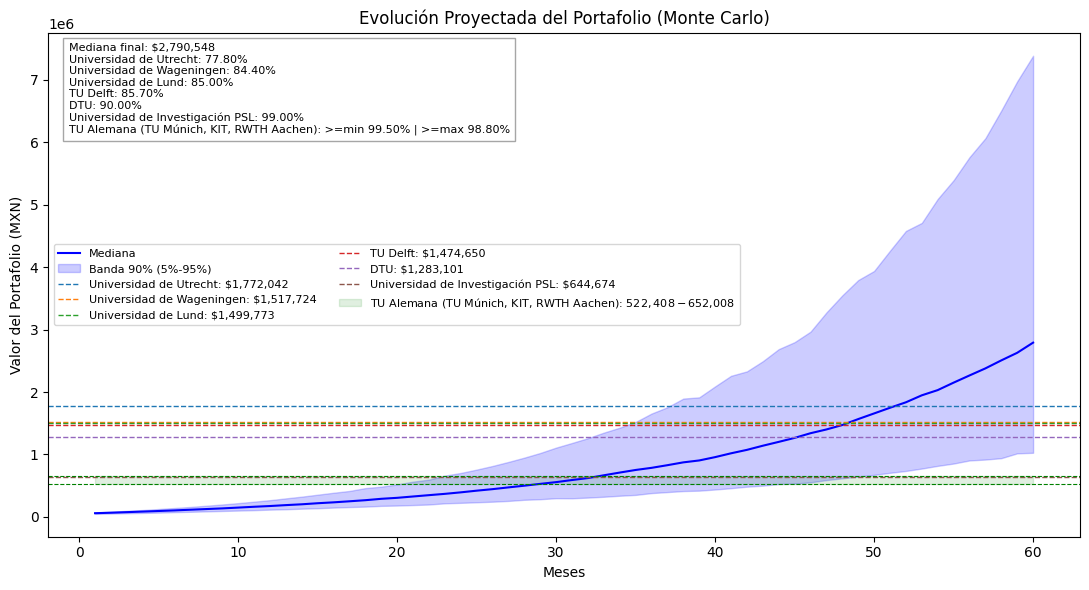

In [2]:
# === Recomendaciones implementadas: anotaciones, exportaciones y parametrización ===
import os

def export_results(final_values, trajectories, goals, range_goal_name, range_goal_min, range_goal_max, out_dir="outputs"):
    """Exporta CSVs con distribución de valores finales, resumen de trayectoria y probabilidades por objetivos."""
    os.makedirs(out_dir, exist_ok=True)
    # 1) Distribución de valores finales
    df_final = pd.DataFrame({"simulation_id": np.arange(1, len(final_values)+1), "final_value": final_values})
    path_final = os.path.join(out_dir, "final_values.csv")
    df_final.to_csv(path_final, index=False, encoding="utf-8")

    # 2) Resumen de trayectorias (percentiles por mes)
    months = np.arange(1, trajectories.shape[1] + 1)
    p5 = np.percentile(trajectories, 5, axis=0)
    p50 = np.percentile(trajectories, 50, axis=0)
    p95 = np.percentile(trajectories, 95, axis=0)
    df_traj = pd.DataFrame({"month": months, "p5": p5, "p50": p50, "p95": p95})
    path_traj = os.path.join(out_dir, "trajectories_summary.csv")
    df_traj.to_csv(path_traj, index=False, encoding="utf-8")

    # 3) Probabilidades por objetivo
    prob_by_goal = {name: float(np.mean(final_values >= value) * 100) for name, value in goals.items()}
    range_min_prob = float(np.mean(final_values >= range_goal_min) * 100)
    range_max_prob = float(np.mean(final_values >= range_goal_max) * 100)

    rows = []
    for name, value in goals.items():
        rows.append({
            "goal_name": name, "type": "fixed", "goal_value_min": value, "goal_value_max": value,
            "prob_ge_min": prob_by_goal[name], "prob_ge_max": prob_by_goal[name]
        })
    rows.append({
        "goal_name": range_goal_name, "type": "range",
        "goal_value_min": range_goal_min, "goal_value_max": range_goal_max,
        "prob_ge_min": range_min_prob, "prob_ge_max": range_max_prob
    })
    df_probs = pd.DataFrame(rows)
    path_probs = os.path.join(out_dir, "probabilities_summary.csv")
    df_probs.to_csv(path_probs, index=False, encoding="utf-8")

    print("Archivos exportados:")
    print(f"- {path_final}")
    print(f"- {path_traj}")
    print(f"- {path_probs}")


def replot_with_annotations():
    """Reproduce las dos gráficas agregando anotaciones de probabilidades para cada objetivo."""
    # Recalcula métricas necesarias para robustez
    median_val = np.median(final_values)
    ci95 = np.percentile(final_values, [2.5, 97.5])
    prob_by_goal = {name: float(np.mean(final_values >= value) * 100) for name, value in goals.items()}
    range_min_prob = float(np.mean(final_values >= range_goal_min) * 100)
    range_max_prob = float(np.mean(final_values >= range_goal_max) * 100)

    # -------- Histograma con anotaciones --------
    plt.figure(figsize=(11, 6))
    plt.hist(final_values, bins=50, edgecolor='black', color='#87CEFA')
    plt.title('Distribución de Posibles Valores del Portafolio en 5 Años')
    plt.xlabel('Valor Final del Portafolio (MXN)')
    plt.ylabel(f'Frecuencia (de {simulations} simulaciones)')
    plt.axvline(median_val, color='red', linestyle='dashed', linewidth=2, label=f'Mediana: ${median_val:,.0f}')

    color_cycle = plt.cm.tab10.colors
    for idx, (name, value) in enumerate(goals.items()):
        plt.axvline(value, color=color_cycle[idx % len(color_cycle)], linestyle='solid', linewidth=1.5, label=f"{name}: ${value:,.0f}")

    # Banda para objetivo en rango (TU Alemana (TU Múnich, KIT, RWTH Aachen))
    plt.axvspan(range_goal_min, range_goal_max, color='green', alpha=0.12, label=f'{range_goal_name}: ${range_goal_min:,.0f}-${range_goal_max:,.0f}')
    plt.axvline(range_goal_min, color='green', linestyle='--', linewidth=1)
    plt.axvline(range_goal_max, color='green', linestyle='--', linewidth=1)

    # Texto de anotaciones con probabilidades
    lines = [f"IC 95%: ${ci95[0]:,.0f} - ${ci95[1]:,.0f}"]
    for name in goals.keys():
        lines.append(f"{name}: {prob_by_goal[name]:.2f}%")
    lines.append(f"{range_goal_name}: >=min {range_min_prob:.2f}% | >=max {range_max_prob:.2f}%")
    text = "\n".join(lines)
    ax = plt.gca()
    ax.text(0.98, 0.98, text, transform=ax.transAxes, ha='right', va='top', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------- Curva de crecimiento con anotaciones --------
    months_local = np.arange(1, trajectories.shape[1] + 1)
    median_curve = np.percentile(trajectories, 50, axis=0)
    p5_curve = np.percentile(trajectories, 5, axis=0)
    p95_curve = np.percentile(trajectories, 95, axis=0)

    plt.figure(figsize=(11, 6))
    plt.plot(months_local, median_curve, color='blue', label='Mediana')
    plt.fill_between(months_local, p5_curve, p95_curve, color='blue', alpha=0.2, label='Banda 90% (5%-95%)')

    for idx, (name, value) in enumerate(goals.items()):
        plt.axhline(value, color=color_cycle[idx % len(color_cycle)], linestyle='--', linewidth=1, label=f"{name}: ${value:,.0f}")

    plt.fill_between(months_local, range_goal_min, range_goal_max, color='green', alpha=0.12, label=f'{range_goal_name}: ${range_goal_min:,.0f}-${range_goal_max:,.0f}')
    plt.axhline(range_goal_min, color='green', linestyle='--', linewidth=0.8)
    plt.axhline(range_goal_max, color='green', linestyle='--', linewidth=0.8)

    # Texto de anotaciones (probabilidades de metas al final del horizonte)
    lines2 = [f"Mediana final: ${median_val:,.0f}"]
    for name in goals.keys():
        lines2.append(f"{name}: {prob_by_goal[name]:.2f}%")
    lines2.append(f"{range_goal_name}: >=min {range_min_prob:.2f}% | >=max {range_max_prob:.2f}%")
    text2 = "\n".join(lines2)
    ax2 = plt.gca()
    ax2.text(0.02, 0.98, text2, transform=ax2.transAxes, ha='left', va='top', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

    plt.title('Evolución Proyectada del Portafolio (Monte Carlo)')
    plt.xlabel('Meses')
    plt.ylabel('Valor del Portafolio (MXN)')
    plt.legend(loc='best', ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()


def run_monte_carlo_with_params(
    initial_investment, monthly_contribution, investment_horizon_years, simulations,
    initial_rics, initial_weights, monthly_rics, monthly_weights,
    goals, range_goal_name, range_goal_min, range_goal_max,
    historical_data=None, years_history=5, end_date=None,
    plot=True, export=True, out_dir="outputs"
):
    """Ejecuta la simulación Monte Carlo con parámetros personalizados y genera gráficos/exportaciones opcionalmente.
    Si no se provee historical_data, descarga datos usando los RICs indicados (requiere sesión LSEG abierta).
    Retorna un diccionario con resultados principales.
    """
    # Datos históricos
    if historical_data is None:
        if end_date is None:
            end_date = pd.to_datetime('today')
        start_date = end_date - pd.DateOffset(years=years_history)
        all_rics_local = list(set(initial_rics + monthly_rics))
        historical_data = ld.get_history(all_rics_local, fields='TR.PriceClose', start=start_date, end=end_date)

    # Rendimientos
    daily_returns = historical_data.pct_change().dropna()
    mean_returns = daily_returns.mean()
    cov_matrix = daily_returns.cov()
    annual_mean_returns = mean_returns * 252
    annual_cov_matrix = cov_matrix * 252

    # Simulación
    num_months = investment_horizon_years * 12
    trajectories_local = np.zeros((simulations, num_months))

    for i in range(simulations):
        init_ret = np.random.multivariate_normal(annual_mean_returns[initial_rics] / 12, annual_cov_matrix.loc[initial_rics, initial_rics] / 12)
        init_val = np.dot(init_ret, initial_weights)
        total_val = initial_investment * (1 + init_val)

        for m in range(num_months):
            mret = np.random.multivariate_normal(annual_mean_returns[monthly_rics] / 12, annual_cov_matrix.loc[monthly_rics, monthly_rics] / 12)
            port_mret = np.dot(mret, monthly_weights)
            total_val = total_val * (1 + port_mret) + monthly_contribution
            trajectories_local[i, m] = total_val

    final_vals_local = trajectories_local[:, -1]
    median_val = np.median(final_vals_local)
    ci95 = np.percentile(final_vals_local, [2.5, 97.5])

    prob_by_goal_local = {name: float(np.mean(final_vals_local >= value) * 100) for name, value in goals.items()}
    range_min_prob = float(np.mean(final_vals_local >= range_goal_min) * 100)
    range_max_prob = float(np.mean(final_vals_local >= range_goal_max) * 100)

    # Exportar y graficar si se solicita
    if export:
        export_results(final_vals_local, trajectories_local, goals, range_goal_name, range_goal_min, range_goal_max, out_dir=out_dir)
    if plot:
        # Variables temporales para reutilizar replot si se desea, o graficar inline aquí
        months_local = np.arange(1, num_months + 1)
        color_cycle = plt.cm.tab10.colors

        # Histograma
        plt.figure(figsize=(11, 6))
        plt.hist(final_vals_local, bins=50, edgecolor='black', color='#87CEFA')
        plt.title('Distribución de Posibles Valores del Portafolio en 5 Años (Custom)')
        plt.xlabel('Valor Final del Portafolio (MXN)')
        plt.ylabel(f'Frecuencia (de {simulations} simulaciones)')
        plt.axvline(median_val, color='red', linestyle='dashed', linewidth=2, label=f'Mediana: ${median_val:,.0f}')
        for idx, (name, value) in enumerate(goals.items()):
            plt.axvline(value, color=color_cycle[idx % len(color_cycle)], linestyle='solid', linewidth=1.5, label=f"{name}: ${value:,.0f}")
        plt.axvspan(range_goal_min, range_goal_max, color='green', alpha=0.12, label=f'{range_goal_name}: ${range_goal_min:,.0f}-${range_goal_max:,.0f}')
        plt.axvline(range_goal_min, color='green', linestyle='--', linewidth=1)
        plt.axvline(range_goal_max, color='green', linestyle='--', linewidth=1)

        lines = [f"IC 95%: ${ci95[0]:,.0f} - ${ci95[1]:,.0f}"]
        for name in goals.keys():
            lines.append(f"{name}: {prob_by_goal_local[name]:.2f}%")
        lines.append(f"{range_goal_name}: >=min {range_min_prob:.2f}% | >=max {range_max_prob:.2f}%")
        ax = plt.gca()
        ax.text(0.98, 0.98, "\n".join(lines), transform=ax.transAxes, ha='right', va='top', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Evolución
        median_curve = np.percentile(trajectories_local, 50, axis=0)
        p5_curve = np.percentile(trajectories_local, 5, axis=0)
        p95_curve = np.percentile(trajectories_local, 95, axis=0)
        plt.figure(figsize=(11, 6))
        plt.plot(months_local, median_curve, color='blue', label='Mediana')
        plt.fill_between(months_local, p5_curve, p95_curve, color='blue', alpha=0.2, label='Banda 90% (5%-95%)')
        for idx, (name, value) in enumerate(goals.items()):
            plt.axhline(value, color=color_cycle[idx % len(color_cycle)], linestyle='--', linewidth=1, label=f"{name}: ${value:,.0f}")
        plt.fill_between(months_local, range_goal_min, range_goal_max, color='green', alpha=0.12, label=f'{range_goal_name}: ${range_goal_min:,.0f}-${range_goal_max:,.0f}')
        plt.axhline(range_goal_min, color='green', linestyle='--', linewidth=0.8)
        plt.axhline(range_goal_max, color='green', linestyle='--', linewidth=0.8)

        ax2 = plt.gca()
        lines2 = [f"Mediana final: ${median_val:,.0f}"]
        for name in goals.keys():
            lines2.append(f"{name}: {prob_by_goal_local[name]:.2f}%")
        lines2.append(f"{range_goal_name}: >=min {range_min_prob:.2f}% | >=max {range_max_prob:.2f}%")
        ax2.text(0.02, 0.98, "\n".join(lines2), transform=ax2.transAxes, ha='left', va='top', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
        plt.title('Evolución Proyectada del Portafolio (Monte Carlo) - Custom')
        plt.xlabel('Meses')
        plt.ylabel('Valor del Portafolio (MXN)')
        plt.legend(loc='best', ncol=2, fontsize=8)
        plt.tight_layout()
        plt.show()

    return {
        "final_values": final_vals_local, "trajectories": trajectories_local,
        "median_final_value": float(median_val), "ci95": ci95.tolist(),
        "prob_by_goal": prob_by_goal_local,
        "range_goal_probs": {"min": range_min_prob, "max": range_max_prob}
    }


# 1) Exportar resultados actuales a CSV
export_results(final_values, trajectories, goals, range_goal_name, range_goal_min, range_goal_max, out_dir="outputs")

# 2) Re-graficar con anotaciones de probabilidades
replot_with_annotations()

# 3) Parametrización: ejemplo de uso (descomenta para ejecutar con otros parámetros)
# new_results = run_monte_carlo_with_params(
#     initial_investment=50000,
#     monthly_contribution=5000,
#     investment_horizon_years=5,
#     simulations=500,
#     initial_rics=initial_rics, initial_weights=initial_weights,
#     monthly_rics=monthly_rics, monthly_weights=monthly_weights,
#     goals=goals,
#     range_goal_name=range_goal_name, range_goal_min=range_goal_min, range_goal_max=range_goal_max,
#     historical_data=historical_data,  # Reutiliza históricos para evitar nueva descarga
#     plot=True, export=True, out_dir="outputs_custom"
# )

In [ ]:
# Gráficas sin leyendas y solo con las líneas necesarias

# Histograma con líneas verticales (mediana y objetivos), sin leyenda
plt.figure(figsize=(11, 6))
plt.hist(final_values, bins=50, edgecolor='black', color='#87CEFA')
plt.axvline(median_final_value, color='red', linestyle='dashed', linewidth=2)  # mediana
# líneas verticales para objetivos fijos
for idx, (gname, gval) in enumerate(goals.items()):
    plt.axvline(gval, color=plt.cm.tab10.colors[idx % 10], linestyle='solid', linewidth=1.5)
# banda rango dibujada solo como líneas en los bordes (sin relleno)
plt.axvline(range_goal_min, color='green', linestyle='--', linewidth=1)
plt.axvline(range_goal_max, color='green', linestyle='--', linewidth=1)
plt.title('Distribución de Valores Finales (sin leyendas)')
plt.xlabel('Valor Final del Portafolio (MXN)')
plt.ylabel(f'Frecuencia (de {simulations} simulaciones)')
plt.tight_layout()
plt.show()

# Curva de crecimiento: solo líneas (mediana, p5, p95) y líneas horizontales para objetivos, sin leyenda ni áreas
plt.figure(figsize=(11, 6))
plt.plot(months, median_curve, color='blue', linewidth=2)       # mediana
plt.plot(months, p5_curve, color='blue', linestyle='--', linewidth=1)   # P5
plt.plot(months, p95_curve, color='blue', linestyle='--', linewidth=1)  # P95
# líneas horizontales para objetivos fijos
for idx, (gname, gval) in enumerate(goals.items()):
    plt.axhline(gval, color=plt.cm.tab10.colors[idx % 10], linestyle='--', linewidth=1)
# líneas horizontales para rango objetivo
plt.axhline(range_goal_min, color='green', linestyle='--', linewidth=1)
plt.axhline(range_goal_max, color='green', linestyle='--', linewidth=1)
plt.title('Evolución Proyectada del Portafolio (sin leyendas)')
plt.xlabel('Meses')
plt.ylabel('Valor del Portafolio (MXN)')
plt.tight_layout()
plt.show()

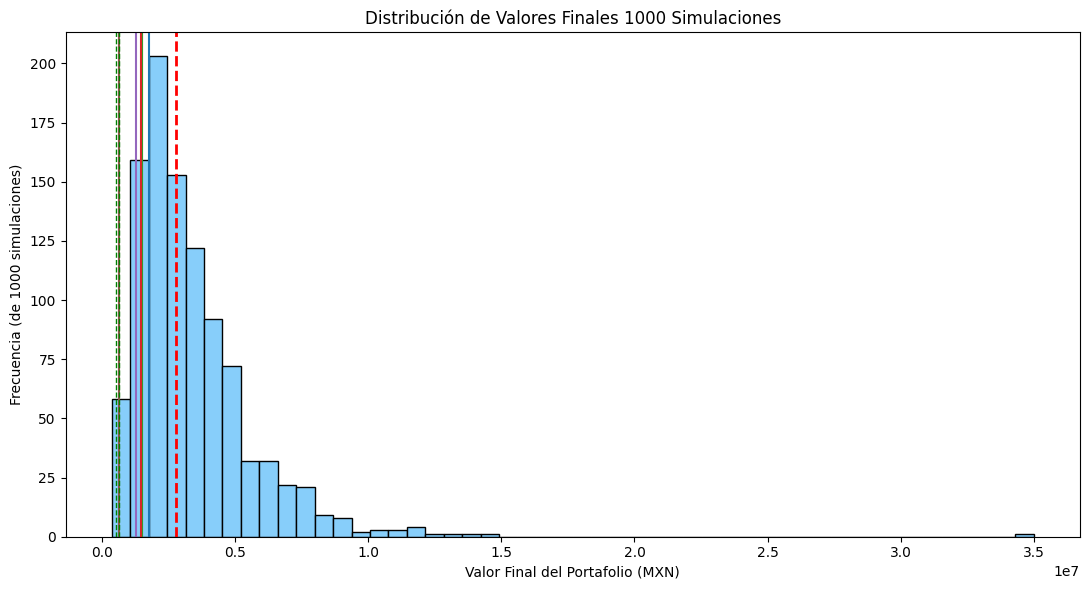

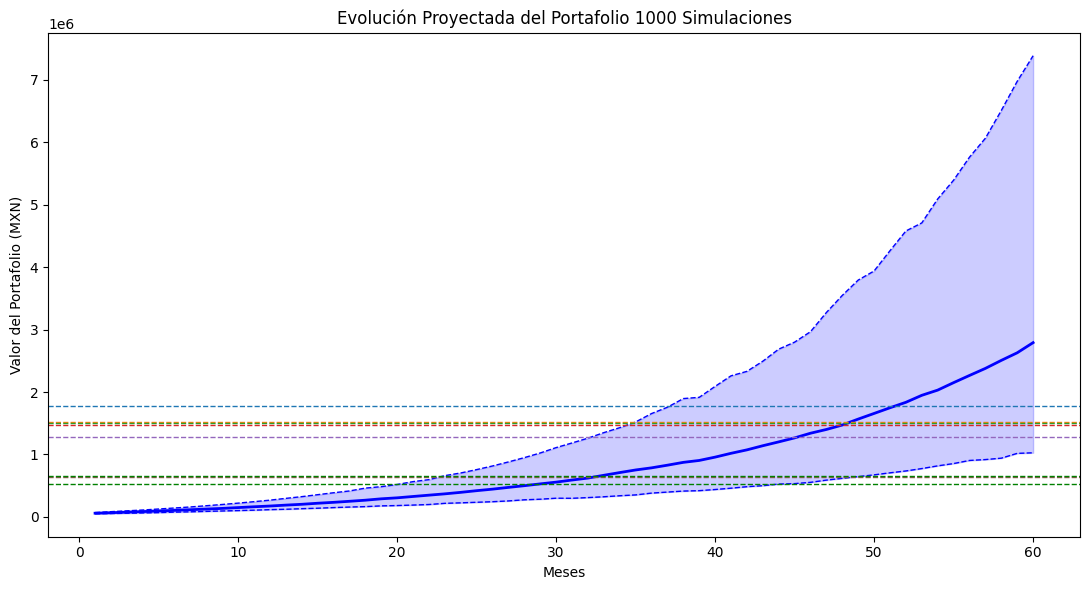

In [6]:
# Gráficas sin leyendas y solo con las líneas necesarias

# Histograma con líneas verticales (mediana y objetivos), sin leyenda
plt.figure(figsize=(11, 6))
plt.hist(final_values, bins=50, edgecolor='black', color='#87CEFA')
plt.axvline(median_final_value, color='red', linestyle='dashed', linewidth=2)  # mediana
# líneas verticales para objetivos fijos
for idx, (gname, gval) in enumerate(goals.items()):
    plt.axvline(gval, color=plt.cm.tab10.colors[idx % 10], linestyle='solid', linewidth=1.5)
# banda rango dibujada solo como líneas en los bordes (sin relleno)
plt.axvline(range_goal_min, color='green', linestyle='--', linewidth=1)
plt.axvline(range_goal_max, color='green', linestyle='--', linewidth=1)
plt.title('Distribución de Valores Finales 1000 Simulaciones')
plt.xlabel('Valor Final del Portafolio (MXN)')
plt.ylabel(f'Frecuencia (de {simulations} simulaciones)')
plt.tight_layout()
plt.show()

# Curva de crecimiento: solo líneas (mediana, p5, p95) y líneas horizontales para objetivos, sin leyenda ni áreas
plt.figure(figsize=(11, 6))
plt.plot(months, median_curve, color='blue', linewidth=2)       # mediana
plt.plot(months, p5_curve, color='blue', linestyle='--', linewidth=1)   # P5
plt.plot(months, p95_curve, color='blue', linestyle='--', linewidth=1)  # P95
plt.fill_between(months, p5_curve, p95_curve, color='blue', alpha=0.2,  # Rellena banda 5%-95%
                 label='Banda 90% (5%-95%)')
# líneas horizontales para objetivos fijos
for idx, (gname, gval) in enumerate(goals.items()):
    plt.axhline(gval, color=plt.cm.tab10.colors[idx % 10], linestyle='--', linewidth=1)
# líneas horizontales para rango objetivo
plt.axhline(range_goal_min, color='green', linestyle='--', linewidth=1)
plt.axhline(range_goal_max, color='green', linestyle='--', linewidth=1)
plt.title('Evolución Proyectada del Portafolio 1000 Simulaciones')
plt.xlabel('Meses')
plt.ylabel('Valor del Portafolio (MXN)')
plt.tight_layout()
plt.show()

In [2]:
import lseg.data as ld  # Importa la librería de datos LSEG (Refinitiv) para descargar históricos
import numpy as np       # Importa NumPy para cálculos numéricos y simulación
import pandas as pd      # Importa pandas para manipulación de datos
import matplotlib.pyplot as plt  # Importa Matplotlib para visualizaciones

# --- Configuración ---
ld.open_session()  # Abre la sesión con LSEG para poder realizar consultas de datos

# Capital inicial (inversión única al inicio)
initial_rics = [  
    "EXLS.OQ", "4901.T", "2301.TW", "REL.L", "MSFT.OQ",
    "ZOREN.IS", "GWIND.IS", "NATEN.IS", "ESEN.IS", "MAGEN.IS"
 ]
initial_weights = np.array([0.09, 0.08, 0.09, 0.09, 0.18, 0.05, 0.10, 0.10, 0.10, 0.12])  # Pesos de la inversión inicial por activo (suma ≈ 1)

# Aportaciones mensuales (se reparten diferente)
# Los rics que faltan tendran 0 de peso en el portafolio con las inversiones de 5,000 mensuales
monthly_rics = [  # Lista de RICs usados para las aportaciones mensuales
    "4901.T", "2301.TW", "ZOREN.IS", "GWIND.IS", 
    "NATEN.IS", "ESEN.IS", "MAGEN.IS"
]
monthly_weights = np.array([0.09, 0.09, 0.06, 0.10, 0.11, 0.20, 0.36])  # Pesos para las aportaciones mensuales


# Monto de inversión y horizonte
initial_investment = 50000      # Monto único que se invierte al inicio (MXN)
monthly_contribution = 5000     # Monto que se aporta cada mes (MXN)
investment_horizon_years = 5    # Horizonte de inversión en años

## Matriz de correlación (5 años) y métricas del portafolio

A continuación:
- Descargamos precios de cierre ajustados de los últimos 5 años desde Refinitiv (lseg.data) para `initial_rics`.
- Calculamos rendimientos diarios, su matriz de correlación y mostramos un mapa de calor.
- Anualizamos rendimientos esperados y covarianzas para estimar:
  - Rendimiento esperado del portafolio (anual)
  - Varianza del portafolio (anual)
  - Desviación estándar del portafolio (anual)

Notas:
- Usa `initial_rics` e `initial_weights` ya definidos en el notebook.
- Requiere que la sesión LSEG esté abierta (`ld.open_session()`).

c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_tools\_dataframe.py:177:FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
C:\Users\Juan Marco\AppData\Local\Temp\ipykernel_18608\2424701929.py:28:FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


Matriz de correlación (diaria, 5 años):


Price Close,EXLS.OQ,4901.T,2301.TW,REL.L,MSFT.OQ,ZOREN.IS,GWIND.IS,NATEN.IS,ESEN.IS,MAGEN.IS
Price Close,,,,,,,,,,
EXLS.OQ,1.000000,0.064645,0.002779,0.169541,0.380116,0.020622,0.026254,0.053024,0.031510,-0.010737
4901.T,0.064645,1.000000,0.151810,0.086745,0.071758,0.015807,0.006891,-0.002797,0.047821,0.023576
2301.TW,0.002779,0.151810,1.000000,0.044430,0.027718,0.044507,0.017339,-0.014917,0.040985,-0.011915
REL.L,0.169541,0.086745,0.044430,1.000000,0.169502,0.042141,0.039983,0.014551,0.021424,0.030659
MSFT.OQ,0.380116,0.071758,0.027718,0.169502,1.000000,0.004507,-0.006856,0.030757,0.006943,-0.004860
ZOREN.IS,0.020622,0.015807,0.044507,0.042141,0.004507,1.000000,0.437244,0.344039,0.338139,0.331218
GWIND.IS,0.026254,0.006891,0.017339,0.039983,-0.006856,0.437244,1.000000,0.330752,0.312180,0.285089
NATEN.IS,0.053024,-0.002797,-0.014917,0.014551,0.030757,0.344039,0.330752,1.000000,0.675285,0.485966
ESEN.IS,0.031510,0.047821,0.040985,0.021424,0.006943,0.338139,0.312180,0.675285,1.000000,0.519701


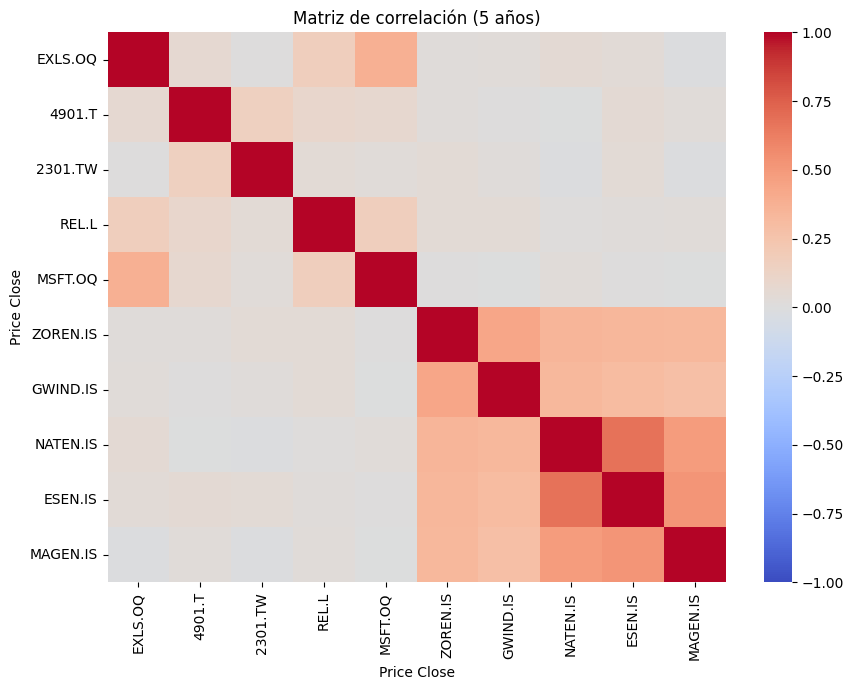


Métricas del portafolio (anualizadas):
- Rendimiento esperado: 53.3093%
- Varianza: 0.070903
- Desviación estándar: 26.6277%


In [3]:
# Correlación 5 años y métricas del portafolio usando Refinitiv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False
import lseg.data as ld

# Asegúrate de tener la sesión abierta (no hace nada si ya está abierta)
try:
    ld.open_session()
except Exception:
    pass

# 1) Descargar 5 años de precios
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(years=5)
rics = initial_rics  # usa la lista dada
initial_weights = np.array([0.046, 0.083, 0.089, 0.047, 0.088, 0.053, 0.100, 0.104, 0.151, 0.239])

data = ld.get_history(rics, fields='TR.PriceClose', start=start_date, end=end_date)

# 2) Rendimientos diarios y correlación
returns = data.pct_change().dropna(how='all')
returns = returns.dropna(axis=1, how='all')  # por si algún ticker no devuelve datos

corr_mat = returns.corr()
print("Matriz de correlación (diaria, 5 años):")
display(corr_mat)

# 3) Heatmap
plt.figure(figsize=(9, 7))
if _HAS_SNS:
    sns.heatmap(corr_mat, annot=False, cmap='coolwarm', center=0, vmin=-1, vmax=1)
else:
    im = plt.imshow(corr_mat, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr_mat.columns)), corr_mat.columns, rotation=90)
    plt.yticks(range(len(corr_mat.index)), corr_mat.index)
plt.title('Matriz de correlación (5 años)')
plt.tight_layout()
plt.show()

# 4) Métricas del portafolio (anualizadas)
# Nota: si algún RIC faltó en 'returns' lo filtramos también en pesos
valid_cols = [c for c in rics if c in returns.columns]
if len(valid_cols) != len(rics):
    print("Aviso: algunos RICs no tienen datos completos y serán excluidos de los cálculos:",
          [c for c in rics if c not in valid_cols])
    # Re-escala pesos a los que sí existen, manteniendo proporciones
    mask = np.array([c in valid_cols for c in rics])
    w = initial_weights[mask]
    w = w / w.sum()
else:
    w = initial_weights

mean_daily = returns[valid_cols].mean()
cov_daily = returns[valid_cols].cov()

mean_annual = mean_daily * 252
cov_annual = cov_daily * 252

# Rendimiento esperado, varianza y desviación estándar del portafolio (anual)
port_exp_return = float(np.dot(w, mean_annual.values))
port_variance = float(np.dot(w, np.dot(cov_annual.values, w)))
port_std = float(np.sqrt(port_variance))

print("\nMétricas del portafolio (anualizadas):")
print(f"- Rendimiento esperado: {port_exp_return:.4%}")
print(f"- Varianza: {port_variance:.6f}")
print(f"- Desviación estándar: {port_std:.4%}")

In [5]:
# Portafolio combinado: inversión inicial + aportaciones mensuales (TWR mensual)
# - Invierte $50,000 el 2020-10-01 con initial_rics/initial_weights
# - Desde 2020-11-01 aporta $5,000 al inicio de cada mes con monthly_rics/monthly_weights
# - Calcula rendimientos mensuales del portafolio (TWR), y métricas anualizadas: retorno esperado, varianza, desviación estándar

import numpy as np
import pandas as pd
import lseg.data as ld

# Parámetros del periodo solicitado
start_date_unified = pd.Timestamp('2020-10-01')
end_date_unified = pd.Timestamp('2025-09-30')

# Asegura sesión abierta (no falla si ya está abierta)
try:
    ld.open_session()
except Exception:
    pass

# Unión de rics y mapas de pesos
init_map = {ric: w for ric, w in zip(initial_rics, initial_weights)}
month_map = {ric: w for ric, w in zip(monthly_rics, monthly_weights)}
all_rics_union = sorted(set(init_map) | set(month_map))

# Descarga precios diarios (cierre ajustado)
# Pedimos unos días antes por seguridad para el primer día hábil del mes
_prices = ld.get_history(
    all_rics_union,
    fields='TR.PriceClose',
    start=start_date_unified - pd.DateOffset(days=5),
    end=end_date_unified
)
prices = _prices.copy()

# Construye retornos mensuales de BMS->BM (primer día hábil a último día hábil de cada mes)
months = pd.period_range(start=start_date_unified.to_period('M'), end=end_date_unified.to_period('M'), freq='M')
idx_bms = months.asfreq('BMS').to_timestamp()
idx_bm = months.asfreq('BM').to_timestamp()

month_starts = prices.resample('BMS').first().reindex(idx_bms)
month_ends = prices.resample('BM').last().reindex(idx_bm)

monthly_returns_df = month_ends.divide(month_starts).subtract(1.0)
monthly_returns_df.index.name = 'month_end'

# Función para retorno ponderado con re-normalización si faltan columnas
from typing import Dict

def weighted_return(row: pd.Series, w_map: Dict[str, float]) -> float:
    cols = [ric for ric in w_map.keys() if ric in row.index and pd.notna(row[ric])]
    if not cols:
        return np.nan
    w = np.array([w_map[ric] for ric in cols], dtype=float)
    w = w / w.sum()
    return float(np.dot(w, row[cols].values))

# Series de retornos mensuales por sub-portafolio
r_init = monthly_returns_df.apply(lambda r: weighted_return(r, init_map), axis=1)
r_month = monthly_returns_df.apply(lambda r: weighted_return(r, month_map), axis=1)

# Simulación determinística de valores y TWR mensual
I_prev = float(initial_investment)
M_prev = 0.0
port_monthly_ret = []
for i, dt in enumerate(monthly_returns_df.index):
    contrib = 0.0 if i == 0 else float(monthly_contribution)  # aporte al inicio de cada mes a partir del 2º mes
    S = I_prev + M_prev + contrib  # valor al inicio del mes después del flujo

    ri = 0.0 if pd.isna(r_init.iloc[i]) else float(r_init.iloc[i])
    rm = 0.0 if pd.isna(r_month.iloc[i]) else float(r_month.iloc[i])

    I_end = I_prev * (1.0 + ri)
    M_end = (M_prev + contrib) * (1.0 + rm)
    V_end = I_end + M_end

    r_t = np.nan if S == 0 else (V_end / S) - 1.0
    port_monthly_ret.append(r_t)

    I_prev, M_prev = I_end, M_end

combined_monthly_returns = pd.Series(port_monthly_ret, index=monthly_returns_df.index, name='combined_TWR_monthly')
combined_monthly_returns = combined_monthly_returns.dropna()

# Métricas anualizadas (en línea con el cálculo anterior: media aritmética mensual * 12)
mean_m = combined_monthly_returns.mean()
var_m = combined_monthly_returns.var(ddof=1)
combined_expected_return_annual = float(mean_m * 12.0)
combined_variance_annual = float(var_m * 12.0)
combined_std_annual = float(np.sqrt(combined_variance_annual))

print('Portafolio combinado (inicial + aportaciones mensuales)')
print(f"Periodo: {combined_monthly_returns.index[0].date()} a {combined_monthly_returns.index[-1].date()}")
print(f"Meses efectivos: {combined_monthly_returns.shape[0]}")
print('\nMétricas anualizadas (TWR mensual):')
print(f"- Rendimiento esperado: {combined_expected_return_annual:.4%}")
print(f"- Varianza: {combined_variance_annual:.6f}")
print(f"- Desviación estándar: {combined_std_annual:.4%}")

# Variables de salida clave:
# - combined_monthly_returns: Serie de rendimientos mensuales TWR del portafolio combinado
# - combined_expected_return_annual, combined_variance_annual, combined_std_annual

c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_tools\_dataframe.py:177:FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


ValueError: BMS is not supported as period frequency